In [1]:
import itertools
import math
import random
import numpy
import matplotlib
import matplotlib.pyplot as plt

# Step 1
Generate Rankings of Relevance for E and P


In [2]:
#Generating all possible combinations of relevance,
#where  0 - N, 1 - R, 2 - HR
possible_rankings = itertools.product([0,1,2], repeat=5)
P = [list(i) for i in possible_rankings]
E = P[:]

#Constructing all possible pairs
L = []
for item1 in P:
    for item2 in E:
        pair = []
        pair.append(item1)
        pair.append(item2)
        L.append(pair)
print "Number of possible ranking pairs: ", len(L)

Number of possible ranking pairs:  59049


# Step 2
Implement Evaluation Measures (Precision@k, DCG@k, RBP)

In [3]:
def precision(res, k = 5):
    counter = 0
    for i in range(k):
        if res[i] != 0:
            counter += 1
    return 1.0*counter / k

def DCG(res, k = 5):
    sum = 0
    for r in range(1,k+1):
        sum += (2**res[r-1] - 1)/math.log(1+r,2)
    return sum

def RBP(res, theta = 0.8):
    sum = 0
    for k in range(1, len(res)):
        sum += res[k-1] * theta**(k-1)*(1 - theta)
    return sum

N=1115
print "Example:"
print " Ranking: ", L[N][1]
print " Precision@4: ", precision(L[N][1],k = 4)
print " DCG@4: ", DCG(L[N][1],k = 4)
print " RBP: ", RBP(L[N][1])

Example:
 Ranking:  [1, 2, 0, 2, 2]
 Precision@4:  0.75
 DCG@4:  4.18481893493
 RBP:  0.7248


# Step 3
 Calculate the 𝛥measure

In [4]:
def delta_measure(pair,measure, k = 5):
    if measure == "precision":
        P = precision(pair[0], k)
        E = precision(pair[1], k)
    if measure == "DCG":
        P = DCG(pair[0], k)
        E = DCG(pair[1], k)
    if measure == "RBP":
        P = RBP(pair[0])
        E = RBP(pair[1])
    return E - P
    

def E_outperforms_G_pairs(pairs, measure, k=5):
    result = []
    for pair in pairs:
        diff = delta_measure(pair,measure,k)
        if diff > 0:
            result.append([pair, diff])
    return result

dcg_res = E_outperforms_G_pairs(L, "DCG")
prec_res = E_outperforms_G_pairs(L, "precision")
rbp_res = E_outperforms_G_pairs(L, "RBP")

print "Number of pairs for which E outperforms P for each measure:"
print " Precision:", len(prec_res)
print " DCG:", len(dcg_res)
print " RBP:", len(rbp_res)

Number of pairs for which E outperforms P for each measure:
 Precision: 21762
 DCG: 29376
 RBP: 29160


# Step 4
Implement Interleaving (Team Draft and Probabilistic)

In our implementations of the generic Team Draft Interleaving and Probabilistic Interleaving, we also consider overlapping documents between the two rankings. To find which documents are the same, we are comparing the labels of the documents.

To make use of this generic algorithm with our rankings, that have relevance as labels, we have to alter the labels so that each one of them is unique. We do that by appending a unique number next to the relevance. For example, after the preprocessing the rankings pair:

[0, 0, 2, 2, 1], [2, 0, 2, 2, 2]

becomes

["00", "01", "22", "23", "14"], ["25", "06", "27", "28", "29"]

In this way, we make sure that there are no overlapping documents between the two rankings, as is required by Note 5 a).

In [5]:
#Team Draft Interleaving

#preprocess the relevance labels of the selected pair so that they are unique
def preprocess(pair):
    c = 0
    new_pair = ([], [])
    for i in range(2):
        for item in pair[i]:
            new_pair[i].append(str(item)+ str(c))
            c+=1
    return new_pair


#a) create the interleaving list
def team_draft_interleave(pair):
    lists = [pair[0][:],pair[1][:]]
    l = []
    a = []
    while lists[0] or lists[1]:
        if lists[0] and lists[1]:
            first = random.randint(0,1)
        elif lists[0]:
            first = 0
        else:
            first = 1
        second = int(math.fabs(first-1))

        #pick from the first list
        doc = lists[first][0]
        l.append(doc)
        a.append(first)
        #delete the doc from the first list (top element) and the second list
        del lists[first][0]   
        try:
            lists[second].remove(doc)     
        except:
            pass
            
        #pick from the second list
        if lists[second]:
            doc = lists[second][0]
            l.append(doc)
            a.append(second) 
            #delete the doc from the second list (top element) and the first list
            del lists[second][0]        
            try:
                lists[first].remove(doc)    
            except:
                pass

    #append the interleaved list with the assignment        
    res = []
    for i in range(len(l)):
        res.append([l[i],a[i]])
    return res #l,a


#generate a list of 'number' amount of uniformly random clicks from list 'l'
#This function has no other purpose than just to show an example of the interleaving algorithm, since no Click Model has been implemented yet
def get_clicks(l, number):
    ind_order = range(len(l))
    random.shuffle(ind_order)
    return ind_order[:number]

#RCM stands for Random Click Model, in which a document has a probability 'r' of being clicked (r = parameters[0])
#SDCM stands for Simple Dependent Click Model (lambdas = parameters)
#default means that a certain amount of random docs will be clicked at random(#clicked docs = parameters[0], default is 2)
def simulate_clicks(interleaved,  click_model = "default", parameters = [2], clicks = None):
    if clicks == None:
        if click_model == "default":
            clicks = get_clicks(interleaved, parameters[0])
        if click_model == "RCM":
            clicks = RCM(interleaved,parameters[0]) #Implemented on Step 5
        if click_model == "SDCM":
            attr  = get_attractiveness(interleaved) #Implemented on Step 5
            clicks = SDCM(attr ,parameters) #Implemented on Step 5
    return clicks
    
    
def outcome_function(c,a):
    """
    Parameters:
        c : list
            A list with the index of all the clicked documents in the interleaved list
        a : list
            The assignment list. Each element is the origin (0 for the first list and 1 for the second list) of the correspoding document in the interleaved list 
    Returns:
        int
            1 if the first list has more clicks
            -1 if the second list has more clicks
            0 if the same amount of clicks
    """
    counters = [0, 0]
    for i in c:
        counters[a[i]]+=1
    return numpy.sign(counters[0]-counters[1])    
    
#b) evaluate the interleaved list
def team_draft_evaluate(interleaved, clicks):
    l, a = zip(*interleaved)
    o = outcome_function(clicks,a)
    return o

def team_draft(pair, click_model = "default", parameters = [2], clicks = None):
    interleaved = team_draft_interleave(pair)
    clicks = simulate_clicks(interleaved,  click_model = click_model, parameters = parameters, clicks = clicks)
    l, a = zip(*interleaved)
    evaluation = team_draft_evaluate(interleaved, clicks)
    return list(l),list(a),clicks,evaluation

pair = L[1232]
no_clicks = 3
print "--TeamDraft Interleaving--"
print "Ranking pair: ", pair
pair = preprocess(pair)
print "Preprocessed:", pair
l,a,clicks,evaluation = team_draft(pair,"default", [no_clicks], clicks = None)
print "Interleaved:", l
print "Assignments:", a
print "Clicks(%d random):"%no_clicks, clicks
print "Comparison:", evaluation

--TeamDraft Interleaving--
Ranking pair:  [[0, 0, 0, 1, 2], [0, 0, 1, 2, 2]]
Preprocessed: (['00', '01', '02', '13', '24'], ['05', '06', '17', '28', '29'])
Interleaved: ['00', '05', '06', '01', '17', '02', '13', '28', '24', '29']
Assignments: [0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Clicks(3 random): [8, 1, 4]
Comparison: -1


In [6]:
#Probabilistic Interleaving

#a) create the interleaving list
def prob_interleave(pair, tau = 3):
    #add to each entry of a ranking the id of the ranking it is from
    lists = [zip(pair[0],[0]*len(pair[0])), zip(pair[1],[1]*len(pair[1]))]
    result = []
    sum = 0
    for i in range(0, len(lists[0])):
        sum += 1.0/((i+1)**tau)
    p = [[(1.0/((i+1)**tau))/sum for i in range(0, len(lists[0]))], [(1.0/((i+1)**tau))/sum for i in range(0, len(lists[0]))]]

    counter = [len(lists[0]),len(lists[1])] # the number of documents left in l1 and l2 
    
    #construct the interleaving by iteratively
    #adding a pair of entries to the resulting list
    while counter[0] > 0 or counter[1] > 0:
        #select the id of the ranking to draw an entry from
        if counter[0] > 0 and counter[1] > 0:
            selected = random.randint(0,1)
        elif counter[0] > 0:
            selected = 0
        else:
            selected = 1
        other_ind = int(math.fabs(selected-1))
        
        #select a new entry with the softmax
        doc_index = numpy.random.choice(range(len(lists[selected])),1,p=p[selected])[0]
        doc = lists[selected][doc_index]
        result.append(doc)
        
        #renormalize the softmax probabilities (do not renormalize if there are no documents left)
        oldp = p[selected][doc_index]
        p[selected][doc_index] = 0
        counter[selected] -= 1
        if counter[selected] > 0: 
            p[selected] = [val/(1.0-oldp) for val in p[selected]]
        
        doc_l = list(doc)
        doc_l[1] = other_ind
        doc = (doc_l[0], doc_l[1])
        if doc in lists[other_ind]:
            ind = lists[other_ind].index(doc)
            oldp = p[other_ind][ind]
            p[other_ind][ind] = 0
            counter[other_ind] -= 1
            if counter[other_ind] > 0:
                p[other_ind] = [val/(1.0-oldp) for val in p[other_ind]]
        
        
    return result
        
    
#b) evaluate the interleaved list
def prob_evaluate(interleaved, clicks):
    return team_draft_evaluate(interleaved, clicks)
   

def probabilistic(pair,  click_model = "default", parameters = [2], clicks = None):
    interleaved = prob_interleave(pair) 
    clicks = simulate_clicks(interleaved,  click_model = click_model, parameters = parameters, clicks = clicks)
    l, a = zip(*interleaved)
    evaluation =  prob_evaluate(interleaved, clicks)
    return list(l),list(a),clicks,evaluation

pair = L[1232]
no_clicks = 3
print "--Probabilistic Interleaving--"
print "Ranking pair: ", pair
pair = preprocess(pair)
print "Preprocessed:", pair
l,a,clicks,evaluation = probabilistic(pair,"default", [no_clicks], clicks = None)
print "Interleaved:", l
print "Assignments:", a
print "Clicks(%d random):"%no_clicks, clicks
print "Comparison:", evaluation

--Probabilistic Interleaving--
Ranking pair:  [[0, 0, 0, 1, 2], [0, 0, 1, 2, 2]]
Preprocessed: (['00', '01', '02', '13', '24'], ['05', '06', '17', '28', '29'])
Interleaved: ['05', '00', '01', '13', '17', '06', '02', '24', '28', '29']
Assignments: [1, 0, 0, 0, 1, 1, 0, 0, 1, 1]
Clicks(3 random): [7, 5, 9]
Comparison: -1


# Step 5
Implement the User Click Models, Random Click Model (RCM) and Simple Dependent Click Model (SDCM)

In [7]:
#read the data from the Yandex Log file
table = []
with open('YandexRelPredChallenge.txt', 'r') as f:
    for line in f:
        line = line.split()
        table.append(line)
f.closed

sum = 0
S = [] #each element in S is a session, i.e. a list of all the DOC_IDs returned for a certain query, and a list of all the documents that were clicked 
for line in table:
    if(line[2]) == 'Q':
        S.append([])
        S[-1].append(line[5:])
        S[-1].append([])
    if(line[2]) == 'C':
        c = line[-1] 
        for i in range(-1,-len(S) - 1, -1): #attribute the click to the last query that had this document as a result
            if c in S[i][0]:
                S[i][1].append(c)
                break;

Calculate the parameter $\rho$ for the Random Click Model (Ranking Independent)

In [8]:
def RCM_parameter(S):
    """
    Estimates the 'r' paramater of the RCM model
    Parameters
        S : list
            A list with all the sessions
    Returns
        float
            The 'r' paramater of the RCM model
    """
    sum1 = 0
    sum2 = 0
    for s in S:
        clicks = set()
        for c in s[1]:
            clicks.add(c)
        sum1 += len(clicks)

        sum2 += len(s[0])

    return 1.0*sum1/sum2


def RCM(l, r):
    """
    Generates a list of clicks from a list of results 
    Parameters
        l : list
            A list of documents
        r : float
            The 'r' parameter of the RCM model, the probability of clicking a document
    Returns
        list
            A list with indexes of all the clicked documents in list l
    """
    c = []
    for i in range(len(l)):
        p = random.uniform(0, 1)
        if p < r:
            c.append(i)
    return c

r = RCM_parameter(S)
print "RCM parameter:", r

RCM parameter: 0.126312951327


Calculate the $\lambda$ parameteres $(\lambda_{1}, \cdots ,\lambda_{10})$ of the Simple Dependent Click Model:

In [9]:
def get_Sr(S, r):
    #S[0][r-1] is the document at rank r-1
    #s[1] is the list of clicks
    return  filter(lambda s: s[0][r-1] in s[1] , S)

def get_lambda_r(S, r):
    Sr = get_Sr(S, r)
    n = len(Sr)
    sum = 0
    for s in Sr:
        indices = [-1] + [s[0].index(doc1) for doc1 in s[1]]
        last_clicked = indices[-1]+1
        additive = 0
        if last_clicked != r:
            additive = 1
        sum += additive
    return sum/float(len(Sr))
        
def get_lambdas(S, maxr=10):
    return [get_lambda_r(S, r) for r in range(1, maxr+1)]

#Returns a list with the attractiveness of each document in the 'interleaved' list based on their relevance
# N = 0
# R = 0.5
# HR = 1
def get_attractiveness(interleaved):
    rel_attr = {}
    rel_attr[0] = 0
    rel_attr[1] = 0.5
    rel_attr[2] = 1
    a = []
    for doc in interleaved:
        rel = int(doc[0][0])
        a.append(rel_attr[rel])
    return a

#get the clicks for the ranked document list, where
#'l_r' is the probability of continuing examination when the document at rank 'r' was clicked
#'a_u' is the attractiveness of document 'u' for this specific query
def SDCM(a_u,l_r):
    clicks = []
    for i in range(len(a_u)):
        p = random.uniform(0,1) #choose if to click
        if p < a_u[i]:
            clicks.append(i) 
            p = random.uniform(0,1) #choose if to stop examining
            if p < l_r[i]:
                continue
            else:
                break
    return clicks


lambdas = get_lambdas(S)
print "SDCM parameters (lambdas):"
for i in range(len(lambdas)):
    print (" l%d ="%i), lambdas[i]

SDCM parameters (lambdas):
 l0 = 0.319429312581
 l1 = 0.53782013103
 l2 = 0.57064311896
 l3 = 0.583973655324
 l4 = 0.577966101695
 l5 = 0.557948717949
 l6 = 0.554520760574
 l7 = 0.505861919236
 l8 = 0.468378506895
 l9 = 0.227272727273


# Step 6
Simulate the Interleaving Experiment for every pair generated in Step 1 

In [13]:
interleavings = ['TeamDraft', 'Probabilistic']
clickModels = ['RCM', 'SDCM']

#Run 'N' simulation of clicks, for a certain pair of rankings 'pair' for every possible combination of interleaving algorithms and click modelss (4 in total). 
#Use the 'calc_score' function as the result of each online evaluation (Wins proportion of E, or the delta, as defined in Step 7)
def run_simulation(pair, N, calc_score):
    result = []
    for interleaving in interleavings:
        int_result = []
        
        #generate interleaved list
        if interleaving == 'TeamDraft':
            interleaved = team_draft_interleave(pair)
        elif interleaving =='Probabilistic':
            interleaved = prob_interleave(pair) 
            
        for clickModel in clickModels:
            wins = 0
            
            #prepare parameters of the selected click model
            parameters = []
            if clickModel == 'RCM':
                parameters = [r]
            elif clickModel == 'SDCM':
                parameters = lambdas
            
            ties = 0
            #generate N samples
            for i in range(N):
                #generate clicks according to the selected click model
                clicks = simulate_clicks(interleaved,click_model = clickModel, parameters = parameters)

                #evaluate the score of the interleaved list with the generated clicks
                if interleaving == 'TeamDraft':
                    score = team_draft_evaluate(interleaved, clicks)
                    if score == 0:
                        ties +=1
                    if score == -1:
                        wins += 1
                elif interleaving =='Probabilistic':
                    score = prob_evaluate(interleaved, clicks)
                    if score == 0:
                        ties +=1
                    if score == -1:
                        wins += 1                    
            int_result.append(calc_score(wins, N, ties))
        result.append(int_result)
        
    return result

#run the simulation with all possible pairs of relevance
def run(L, N, calc_score):
    result = []
    for pair in L:
        result.append(run_simulation(preprocess(pair), N, calc_score))
    return result

wins_proportion = lambda wins, N, ties: wins/float(N) #percentage of wins for E
delta = lambda wins, N, ties: (wins+ties*0.5)/float(N) - 0.5 #delta_PE as defined on step 7

simulated = run(L, 5, wins_proportion)
print "Example"
print "Ranking pairs: ", L[10]
print "Wins percentage for only 5 simulations:"
for i in range(len(interleavings)):
    for j in range(len(clickModels)):
        print " %s(%s):"%(interleavings[i],clickModels[j]),simulated[10][i][j]

Example
Ranking pairs:  [[0, 0, 0, 0, 0], [0, 0, 1, 0, 1]]
Wins percentage for only 5 simulations:
 TeamDraft(RCM): 0.0
 TeamDraft(SDCM): 1.0
 Probabilistic(RCM): 0.6
 Probabilistic(SDCM): 0.6


# Step 7
 Results and Analysis

To make the comparison between measures of offline and online evaluation, we use all of the previously generated pairs of rankings, which are variations of 3 relevance labels. For every pair we calculate all the offline measures (Precision, DCG, RBP) and then we run a simulations with 50 iterations on each combination of interleaving (Team Draft, Probabilistic) and click model (RCM, SDCM).

There is an issue with using the proportion of wins (p) measure when performing online evaluation. If $p>0.5$ for the pair (P,E), then we know that E is winning, but if $p<0.5$, it doesn't neceserilly mean that P is winning. It could be that there are a number of ties reducing p, but overall E might still win or it might be a tie. This uncertainty leads to inaccuracy when comparing if the offline and online measure agree on E losing or a tie. To solve this issue, for an online method measure, we use $\Delta_{PE} = \frac{wins(E) + 0.5\cdot ties(P, E)}{N} - 0.5$. This measure considers the ties, which results in an increase of the accuracy of our comparison. It's values can be interpreted as following: $\Delta_{PE}<0$ - P wins, $\Delta_{PE}=0$ - tie, $\Delta_{PE}>0$ - E wins. In practice, we noticed only small differences of the result of this metric compared to proportion of wins (1-4% difference in agreement). That is possibly caused by the small number of ties in respect to all of the results.

In [136]:
#the 'scores' list keeps the results of all the offline and all the online evaluations for every ranking pair.
#scores[i][0] is a list with the delta_measure for all the offline evaluations for the ith ranking pair,
#while scores[i][1] stores the results of all the online evaluations for the same pair, using the delta_PE measure as explained above 
#50 simulations are run for the online scores
scores = []
for pair in L:
    offline_evaluations = [delta_measure(pair,"precision"), delta_measure(pair,"DCG"), delta_measure(pair,"RBP")]
    online_evaluations = run_simulation(preprocess(pair), 50, delta)
    scores.append([offline_evaluations, online_evaluations])

Once we have the measures, we generate a graph for each possible combination of an offline measure and an online measure. On each graph, the x axis represents the online score ($\Delta_{PE}$) and the y axis - the offline score ($\Delta measure$). Correlation coefficients for all of the graphs are also computed, so they can be used to support observations. Agreement percentages are also calculated.

In [68]:
off_names = ["Precision", "DCG", "RBP"]

results_ca = [] #correlation and agreement percentage (for every ranking pair) for every possible combination of offline and online evaluation

for i in range(len(off_names)): #for each offline evaluation
    results_ca.append([])
    for j in range(len(interleavings)): #for each interleaving algorithm
        for k in range(len(clickModels)): #for each click model
            
            xy = map(lambda x: (x[0][i],x[1][j][k]) , scores)
            x,y = zip(*xy)

            correlation =  numpy.corrcoef(x,y)[0][1]
            
            same = 0
            for t in range(len(x)):
                if numpy.sign(x[t]) == numpy.sign(y[t]): #-0.5 for wins_proportion
                    same+=1
            agreement = 1.0*same/len(x)
            
            results_ca[-1].append([correlation,agreement])
            print  "%s-%s(%s):"%(off_names[i],interleave_names[j],cm_names[k])
            print "  Correlation:", correlation      
            print "  Agreement:", agreement

Precision-Team Draft(RCM):
  Correlation: -0.0018442941381
  Agreement: 0.35909160189
Precision-Team Draft(SDCM):
  Correlation: 0.520803152215
  Agreement: 0.550339548511
Precision-Probabilistic(RCM):
  Correlation: -0.0034498869844
  Agreement: 0.360243187861
Precision-Probabilistic(SDCM):
  Correlation: 0.405389636828
  Agreement: 0.49624887805
DCG-Team Draft(RCM):
  Correlation: -0.000888814096813
  Agreement: 0.45916103575
DCG-Team Draft(SDCM):
  Correlation: 0.743820541456
  Agreement: 0.787633998882
DCG-Probabilistic(RCM):
  Correlation: -0.0032771660646
  Agreement: 0.460024725228
DCG-Probabilistic(SDCM):
  Correlation: 0.529239009724
  Agreement: 0.678063980762
RBP-Team Draft(RCM):
  Correlation: -1.11247963582e-05
  Agreement: 0.456485291876
RBP-Team Draft(SDCM):
  Correlation: 0.740235839266
  Agreement: 0.783620383072
RBP-Probabilistic(RCM):
  Correlation: -0.00130654967548
  Agreement: 0.45699334451
RBP-Probabilistic(SDCM):
  Correlation: 0.519097643048
  Agreement: 0.6683

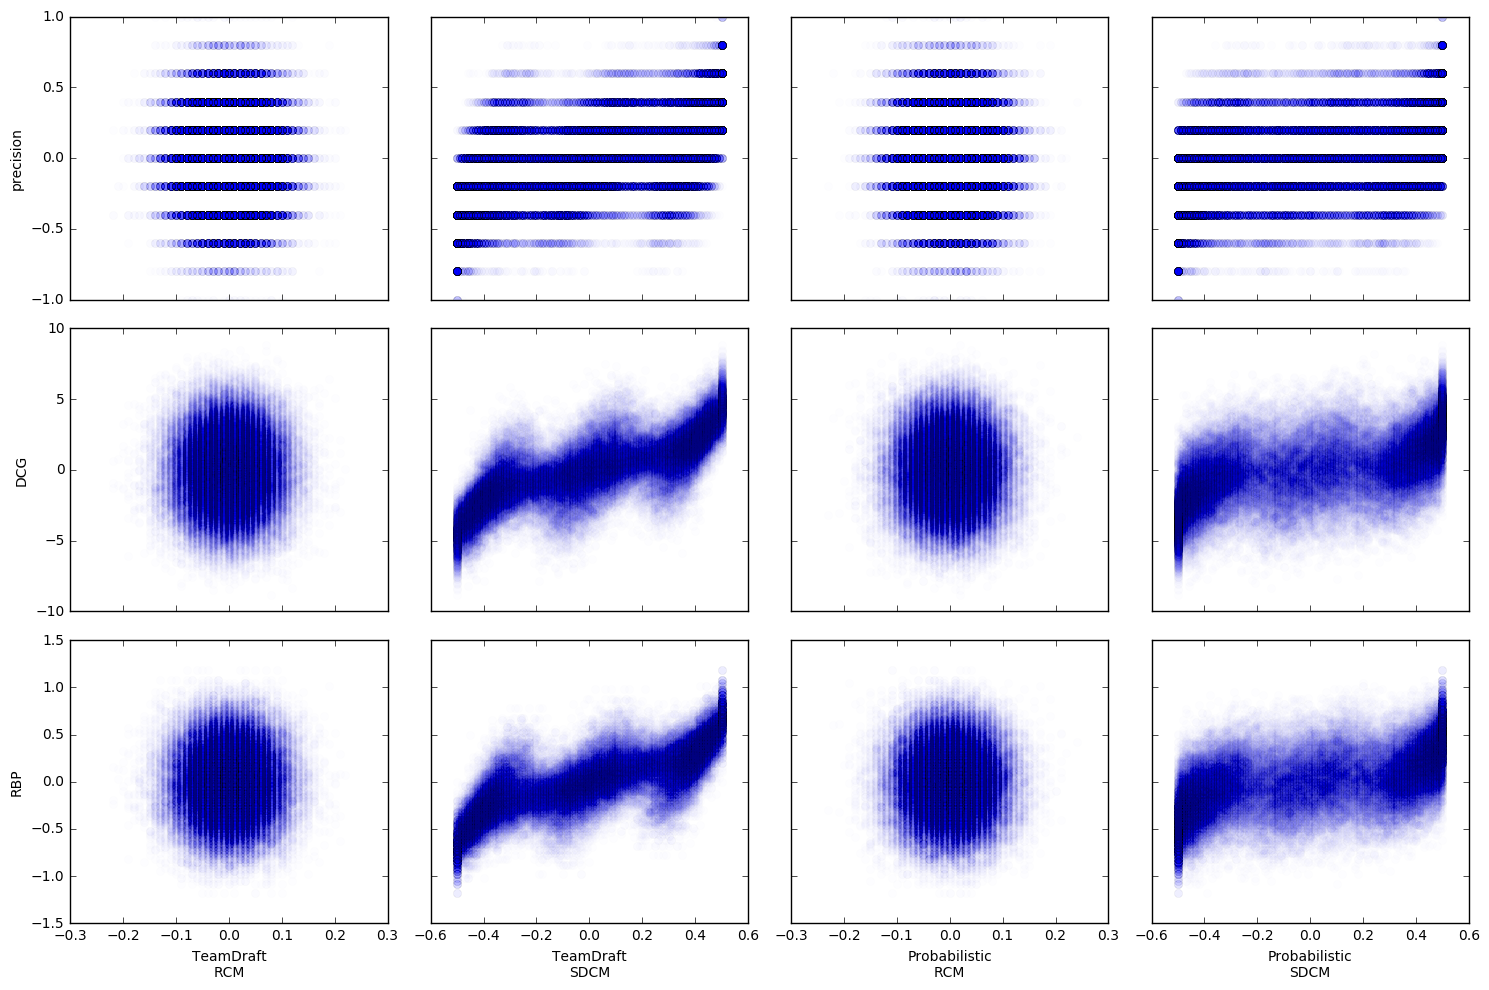

In [62]:
offline_names = ['precision','DCG', 'RBP']

def plot_offline_online(scores):
    f, (ax) = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(15, 10))

    for offline_ind in range(3):
        offline_scores_vals = map(lambda x: x[0][offline_ind], scores) #map(lambda x: x[1], offline_scores)
        i = 0

        ax[offline_ind][0].set_ylabel(offline_names[offline_ind])

        for interleaving_ind in range(2):
            for click_model_ind in range(2):
                online_scores_vals =  map(lambda x: x[1][interleaving_ind][click_model_ind], scores)
                ax[offline_ind][i].plot(online_scores_vals, offline_scores_vals, 'bo', alpha=0.008)

                if offline_ind == 2:
                    ax[offline_ind][i].set_xlabel(interleavings[interleaving_ind] + '\n' + clickModels[click_model_ind])

                i+=1
                plt.tight_layout()
    plt.show()
    
plot_offline_online(scores)

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0" rowspan="2">Correlation</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center" colspan="2">Team Draft<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center;vertical-align:top" colspan="2">Probabilistc</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center">SDCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center;vertical-align:top">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center;vertical-align:top">SDCM</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right">Precision</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center">-0.001</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center">0.52</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">-0.003</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0.405</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">DCG</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0.743</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">-.003<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0.529</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">RBP</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0.74</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">-0.01</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">0.519</td></tr></table>





From the results we can make the following conclusions:

* The graphs where RCM was used don't show any visible correlation between the respective offline measure and online measure (regardless of interleaving). This can be proved by the zero value of the graphs' correlation coefficients.

* In all the graphs with SDCM usage, a positive correlation between offline and online measure can be observed. This statement is enforced by the high correlation coefficients(more than 0.5).

* If the interleavings are compared when using SDCM, we see that with Team Draft the correlation is more strongly expressed (correlation coefficients around 0.74 - strong positive relationship) than with Probabilistic (correlation coefficients around 0.52 - moderate positive relationship). 

* It can be noticed that the values of correlation coefficients when using Precision are lower than when using other offline metrics. This means that precision doesn't relate so well to the online metrics.

But we can't draw a conclusion about the agreement of our offline and online evaluations from the correlation alone. We have to measure the percentage of agreement between all these pairs of offline-online evaluations. An offline measure and an online measure agree when $sgn(\Delta measure) = sgn (\Delta_{PE})$. On the table below we can see the agreement percent for each evaluation and for each interleaving algorithm, along with its click model, similar to the correlation table.

<table style="border-collapse:collapse;border-spacing:0;border-color:#ccc"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0" rowspan="2">Agreement</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center" colspan="2">Team Draft<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;text-align:center;vertical-align:top" colspan="2">Probabilistc</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center">SDCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center;vertical-align:top">RCM</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:center;vertical-align:top">SDCM</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right">Precision</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center">36%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center">55%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">36%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">50%<br></td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">DCG</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">46%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">79%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">46%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">68%<br></td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#efefef;font-weight:bold;text-align:right;vertical-align:top">RBP</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">46%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">78%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">46%<br></td><td style="font-family:Arial, sans-serif;font-size:14px;padding:12px 8px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;text-align:center;vertical-align:top">67%<br></td></tr></table>

* As expected from the correlation analysis, neither of the two online evaluations has a high agreement with the offline evaluations when the clicks are generated by the Random Click Model, as the agreement percentage is on the range of 36-46%.
* The Simple Dependent Click Model does a much better job at generating clicks so that the online evaluation will agree more with the offline evaluation, for every pair of offline-online evaluation.
* We notice that the Interleaving methods agree more with the DCG and RBP rather than with the Precision, presumably because of the graded relevance and the fact that Precision doesn't consider the order of the documents, both of which are important for the SDCM on the interleaving algorithms.
* The agreement between the online evaluations and the RBP is very similar with the agreements with the DCG, probably because the decisions made by DCG about which algorithm is better, P or E, is quite similar with the decisions of RBP (around 89%).
* We notice that the Team Draft Interleaving has a higher agreement with the offline evaluations than the Probabilistic Interleaving does (with RCM they are the same, but agreement is quite low). 
* Overall, the highest agreement is between DCG and Team Draft Interleaving with SDCM(79%)

In [63]:
#computing similarity between DCG and RBP
sum = 0
for pair in L:
    _dcg = delta_measure(pair,"DCG")
    _rbp = delta_measure(pair,"RBP")
    
    if numpy.sign(_dcg) ==  numpy.sign(_rbp):
        sum+=1
        
print sum*1.0/len(L)

0.88717844502
